# Behind the Mask: Deep Learning for Face Mask Detection

In [ ]:
# Packages related to NN
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Packages related to data
from torchvision import datasets
from torch.utils.data import DataLoader

# Packages related to image transformations
import torchvision
from torchvision import transforms

# Package for visualization
import matplotlib.pyplot as plt

# Package for array data
import numpy as np

## Useful function

In [48]:
# Function to create confusion matrix
def create_confusion_matrix(y_value, y_pred, title = 'Confusion Matrix'):
    conf_matrix = metrics.confusion_matrix(y_value, y_pred)

    # Display the  confusion matrix
    # Class 1 means WithoutMask and 0 otherwise
    display_conf = metrics.ConfusionMatrixDisplay(
        conf_matrix,
        display_labels=['Class 0', 'Class 1']
        )

    display_conf.plot(cmap='Blues', values_format='d')

    plt.title(title)
    plt.show()

### Image transformation

In [2]:
image_preprocessing = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
        )
])

### Load the dataset

In [3]:
# Get the image path
path = "/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/"

# Load data
data = {
    'Train': datasets.ImageFolder(
        root=path+"Train",
        transform=image_preprocessing
    ),
    'Test': datasets.ImageFolder(
        root=path+"Test",
        transform=image_preprocessing
    ),
    'Validation': datasets.ImageFolder(
        root=path+"Validation",
        transform=image_preprocessing
    )
}

# Dataloaders
dataloaders = {
    "Train": DataLoader(data["Train"], batch_size = 100, shuffle = True),
    "Test": DataLoader(data["Test"], batch_size = 100, shuffle = True),
    "Validation": DataLoader(data["Validation"], batch_size = 100, shuffle = True)
}

## It is always a good practice to see how our data look like

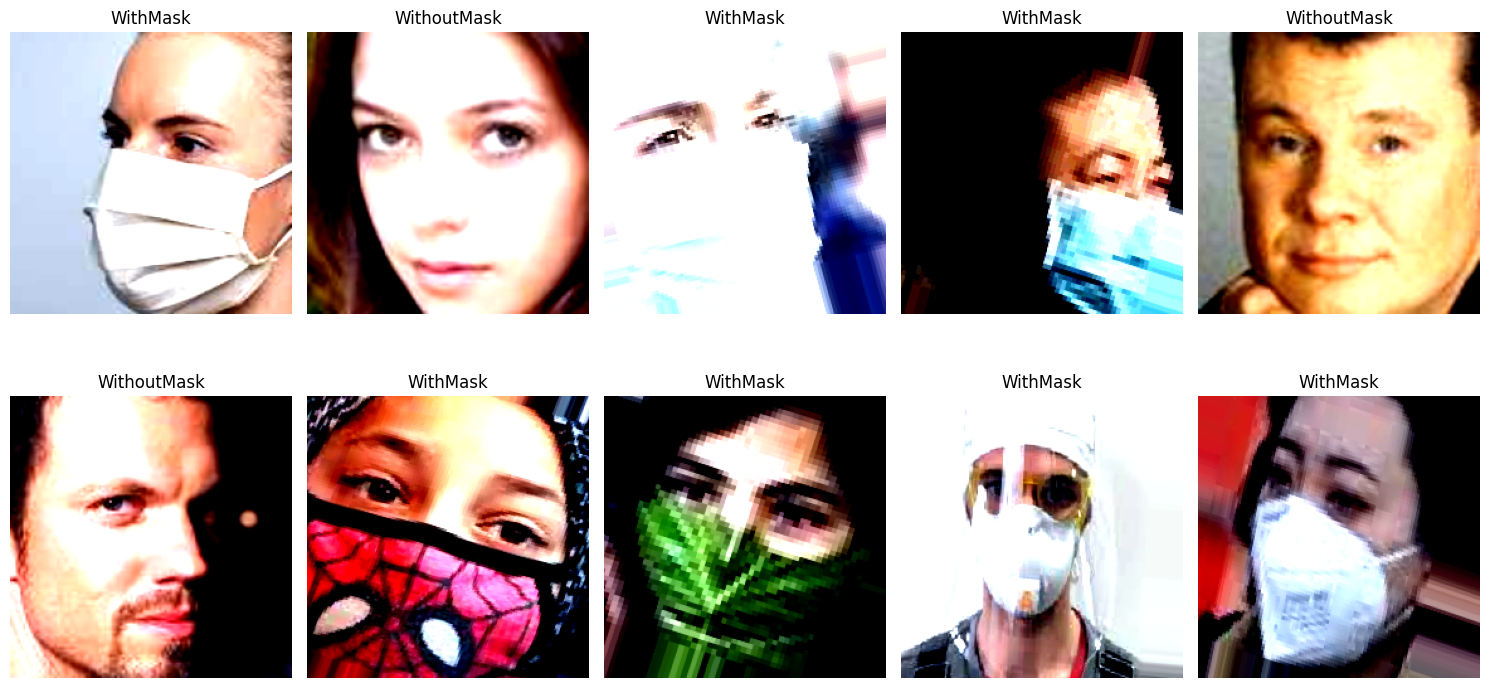

In [13]:
# Define the class labels
class_labels = ['WithMask', 'WithoutMask']

# Get a batch of training data
dataiter = iter(dataloaders['Train'])
images, labels = next(dataiter)

# Function to show images with labels
def imshow_with_labels(img, label):
    img = img / 2 + 0.5
    img = np.clip(img, 0, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f"{class_labels[label]}")
    plt.axis("off")

# Subplot to display 10 images
plt.figure(figsize=(15, 8))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    index = np.random.randint(0, len(images))
    imshow_with_labels(torchvision.utils.make_grid(images[index]), labels[index].item())

plt.tight_layout()
plt.show()

# Load model

In [14]:
%%capture
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

## Model freezing

In [15]:
for parameter in model.parameters():
    parameter.requires_grad = False

## Add new layers

In [16]:
model.classifier[1] = nn.Sequential(
    nn.Linear(1280, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(32, 2),
    nn.LogSoftmax(dim=1)
)

In [17]:
## Check how many learnable parameters do we have
print(sum(model_param.numel() for model_param in model.parameters() if model_param.requires_grad))

371234


## Function to train the model

In [18]:
def train(
        model,
        criterion,
        train_loader,
        validation_loader,
        optimizer,
        epochs,
        device
):

    model_metrics = {'training_loss': [], 'validation_accuracy': []}

    for epoch in range(epochs):
        running_loss = 0

        for inputs, targets  in train_loader:
            optimizer.zero_grad()
            
            # Use GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Make prediction
            output = model(inputs)

            # Calculate the loss
            loss = criterion(output, targets)

            loss.backward()
            optimizer.step()

            running_loss += loss.data.item()

        model_metrics['training_loss'].append(running_loss)

        model.eval()

        # track correct prediction
        correct = 0
        for inputs, targets in validation_loader:
            
            # Use GPU
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Make prediction
            output = model(inputs)

            # Get the class that has the maximum value
            _, label = torch.max(output, 1)

            # Check if the predicted value matches with the actuall class
            correct += (label == targets).sum().item()

        accuracy = 100 * (correct / len(validation_loader.dataset))

        model_metrics['validation_accuracy'].append(accuracy)

        print('Epoch: {}, Training Loss: {:.4f}, Validation Accuracy: {:.4f}%'.format(
            epoch + 1,
            running_loss,
            accuracy
        ))

    return model_metrics

## Training setup

In [19]:
## Create the loss function criterion
criterion = nn.CrossEntropyLoss()

## Create the optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.001)

## Define the number of epochs
epochs = 20

## Leverage GPU resources to expedite the training process.

In [20]:
#checking GPU Avaibility
if torch.cuda.is_available():
    print('GPU is available')
    device = torch.device("cuda:0")
else:
    print('training on CPU')
    device = torch.device("cpu")


GPU is available


# Train the model

In [21]:
# Move model to GPU before training
model.to(device)

# Train the model
training_model = train(model, 
                       criterion, 
                       dataloaders['Train'], 
                       dataloaders['Validation'], 
                       optimizer, 
                       epochs,
                        device)

Epoch: 1, Training Loss: 10.9122, Validation Accuracy: 99.2500%
Epoch: 2, Training Loss: 1.3269, Validation Accuracy: 99.6250%
Epoch: 3, Training Loss: 1.0686, Validation Accuracy: 97.2500%
Epoch: 4, Training Loss: 0.8511, Validation Accuracy: 99.6250%
Epoch: 5, Training Loss: 0.5476, Validation Accuracy: 99.6250%
Epoch: 6, Training Loss: 0.4231, Validation Accuracy: 99.6250%
Epoch: 7, Training Loss: 0.1674, Validation Accuracy: 98.5000%
Epoch: 8, Training Loss: 1.1685, Validation Accuracy: 99.6250%
Epoch: 9, Training Loss: 0.1325, Validation Accuracy: 99.7500%
Epoch: 10, Training Loss: 0.1245, Validation Accuracy: 99.6250%
Epoch: 11, Training Loss: 0.6719, Validation Accuracy: 99.6250%
Epoch: 12, Training Loss: 0.2675, Validation Accuracy: 99.6250%
Epoch: 13, Training Loss: 0.0955, Validation Accuracy: 99.6250%
Epoch: 14, Training Loss: 0.7280, Validation Accuracy: 99.7500%
Epoch: 15, Training Loss: 0.0337, Validation Accuracy: 99.7500%
Epoch: 16, Training Loss: 0.0043, Validation Acc

### Evaluate the model on the training data

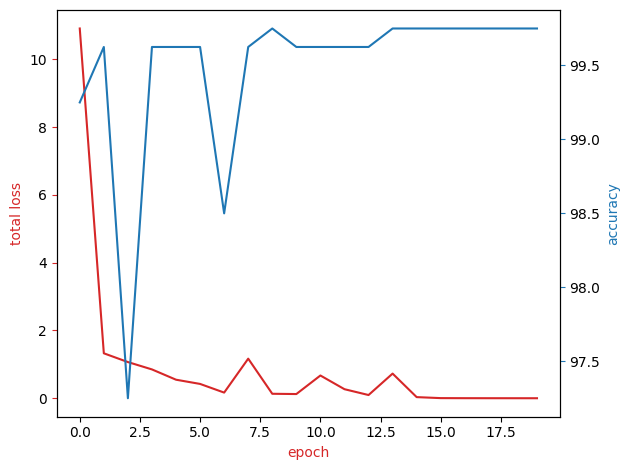

In [51]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(training_model['training_loss'], color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('total loss', color=color)
ax1.tick_params(axis = 'y', color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.plot(training_model['validation_accuracy'], color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()
plt.show()

## Test the model on our test data

In [37]:
def test(model, criterion, test_loader, device):
    model.eval()
    test_losses = []
    correct = 0
    
    test_metrics = {
        "predictions": [],
        "targets_list": []
    }
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            output = model(inputs)

            loss = criterion(output, targets)
            test_losses.append(loss.item())

            _, predicted = torch.max(output, 1)
            correct += (predicted == targets).sum().item()

            # Append predictions and targets to lists
            test_metrics["predictions"].extend(predicted.cpu().numpy())
            test_metrics["targets_list"].extend(targets.cpu().numpy())

    average_test_loss = sum(test_losses) / len(test_losses)
    accuracy = 100 * correct / len(test_loader.dataset)

    print('Test Loss: {:.4f}, Test Accuracy: {:.4f}%'.format(average_test_loss, accuracy))

    return average_test_loss, accuracy, test_metrics, test_losses

In [38]:
# Test the model and get the results in lists
test_loss, test_accuracy, test_metrics, test_loss = test(model, 
                                                    criterion, 
                                                    dataloaders['Test'], 
                                                    device)

Test Loss: 0.0167, Test Accuracy: 99.7984%


## Print classification report

In [47]:
from sklearn import metrics

print(metrics.classification_report(
    test_metrics["targets_list"],
    test_metrics["predictions"]
))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       483
           1       1.00      1.00      1.00       509

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992



## Plot the confusion matrix

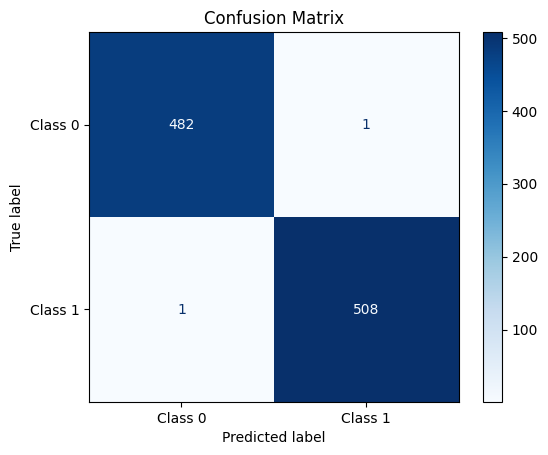

In [50]:
# Import the function we created above
create_confusion_matrix(
    test_metrics["targets_list"],
    test_metrics["predictions"]
)

### I'm still in the process of learning, so if you have any comments, suggestions, or questions about my code, please feel free to share your insights. I'm eager to improve and welcome any feedback you might have.